# This notebook shows handwritten ICA class. It's more reliable to use MNE than this one tho.

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ICA:
    def __init__(self):
        pass

    def center(self, x):
        """
        This method centers the data by subtracting the mean of each sample from the data.
        we do it to make the data have a mean of zero.
        
        param x: The data to be centered
        return: The centered data and the mean of each sample
        """
        mean = np.mean(x, axis=1, keepdims=True)
        centered = x - mean
        return centered, mean

    def covariance(self, x):
        """
        This method calculates the covariance matrix of the data.
        Covariance matrix is calculated as the sum of the covariance matrices of each sample.
        Covariance is a measure of how much changes in one variable affect the other variable.
        
        param x: The data to calculate the covariance matrix for
        return: The covariance matrix of the data
        """
        # mean_x = np.mean(x, axis=-1, keepdims=True)
        m = self.center(x)[0]
        
        # calculate the covariance matrix for each sample
        cov_matrices = []
        for i in range(m.shape[-1]):
            cov_matrix = m[..., i].T.dot(m[..., i]) / (m.shape[-1] - 1)
            cov_matrices.append(cov_matrix)
        
        total_cov_matrix = np.sum(np.stack(cov_matrices), axis=0) / len(cov_matrices)
        
        return total_cov_matrix

    def whiten(self, x):
        """
        This method whitens the data by transforming it to a space where the covariance matrix is the identity matrix.
        Whitening is done by calculating the eigenvalues and eigenvectors of the covariance matrix of the data.
        The data is then transformed to the space spanned by the eigenvectors.
        Eigenvectors are the directions along which the data varies the most.
        
        param x: The data to be whitened
        return: The whitened data and the whitening matrix
        """
        coVarM = self.covariance(x)
        U, S, V = np.linalg.svd(coVarM)
        d = np.diag(1.0 / np.sqrt(S))
        whiteM = np.dot(U, np.dot(d, U.T))
        Xw = np.dot(whiteM, x)
        return Xw, whiteM

    def fastICA(self, signals, alpha=1, thresh=1e-6, iterations=300):
        """
        This method performs Independent Component Analysis (ICA) on the data.
        ICA is a technique used to separate a multivariate signal into additive, independent components.
        It is used to separate the data into independent sources.
        
        param signals: The data to be separated
        param alpha: The non-linearity parameter
        param thresh: The convergence threshold
        param iterations: The maximum number of iterations
        return: The separated data
        """
        signals = signals.reshape(signals.shape[0], -1)
        m, n = signals.shape
        Weights = np.random.rand(m, m)

        for component in range(m):
            w = Weights[component, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):
                weighted_signal = np.dot(w.T, signals)
                weight_g = np.tanh(weighted_signal * alpha).T
                weight_g_ = (1 - np.square(np.tanh(weighted_signal))) * alpha
                new_weight = (signals * weight_g.T).mean(axis=1) - weight_g_.mean() * w.squeeze()
                new_weight = new_weight - np.dot(np.dot(new_weight, Weights[:component].T), Weights[:component])
                new_weight = new_weight / np.sqrt((new_weight ** 2).sum())
                lim = np.abs(np.abs((new_weight * w).sum()) - 1)
                w = new_weight
                i += 1

            Weights[component, :] = w.T
        return Weights

    def fit_transform(self, X):
        X_center, meanX = self.center(X)
        X_whiten, whiteM = self.whiten(X_center)
        W = self.fastICA(X_whiten, alpha=1)
        unMixed = X_whiten.T.dot(W.T)
        
        # reshape mean vector to match the shape of the whitened data
        meanX = np.transpose(meanX, (1, 0, 2))

        unMixed = (unMixed.T - meanX).T

        return unMixed

In [ ]:
epochs_path = "0d4fb30d-epo.fif"
epochs = mne.read_epochs(epochs_path)

In [4]:
mne.epochs.EpochsFIF

mne.epochs.EpochsFIF

In [5]:
X = epochs.get_data()
y = epochs.events[:, 2]
type(X), type(y)

/tmp/ipykernel_116737/1732437555.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


(numpy.ndarray, numpy.ndarray)

In [6]:
X.shape, y.shape

((360, 4, 250), (360,))

In [7]:
ica = ICA()

X = np.transpose(X, (1, 2, 0))

unMixed = ica.fit_transform(X)

In [8]:
unMixed

array([[[-1.12209378e+01,  9.04659264e+00, -7.31827442e+00, ...,
          2.89100523e+00,  2.64678732e-01, -8.61584946e-07],
        [-4.57475130e+00,  6.51625167e+00, -4.05310076e+00, ...,
          2.70852693e+00,  2.23143561e+00, -7.26415060e-06],
        [ 9.99019021e+00, -1.39821455e+01,  7.83368361e+00, ...,
         -1.30257824e+01, -2.62641606e+00,  8.55043584e-06],
        [ 8.92022816e+00, -1.34921746e+01,  1.24090430e+01, ...,
          2.45684312e+01, -1.68834701e+00,  5.48965470e-06]],

       [[ 6.40846554e+00, -2.76933605e+00, -2.43614639e+00, ...,
          3.26370478e+00, -5.17213289e+00,  1.68484054e-05],
        [ 4.61726294e+00, -5.64865441e+00, -4.38961498e-01, ...,
          1.90410934e+00, -2.62757483e-01,  8.57641247e-07],
        [ 3.98033212e+00, -3.74272264e+00,  1.53299952e+01, ...,
          9.17634872e-01, -6.67172318e+00,  2.17360006e-05],
        [-1.44795784e+01,  9.23264369e+00, -6.39573244e+00, ...,
          2.87967749e+00,  3.51911144e-01, -1.15058

In [11]:
unMixed.shape

(360, 4, 250)

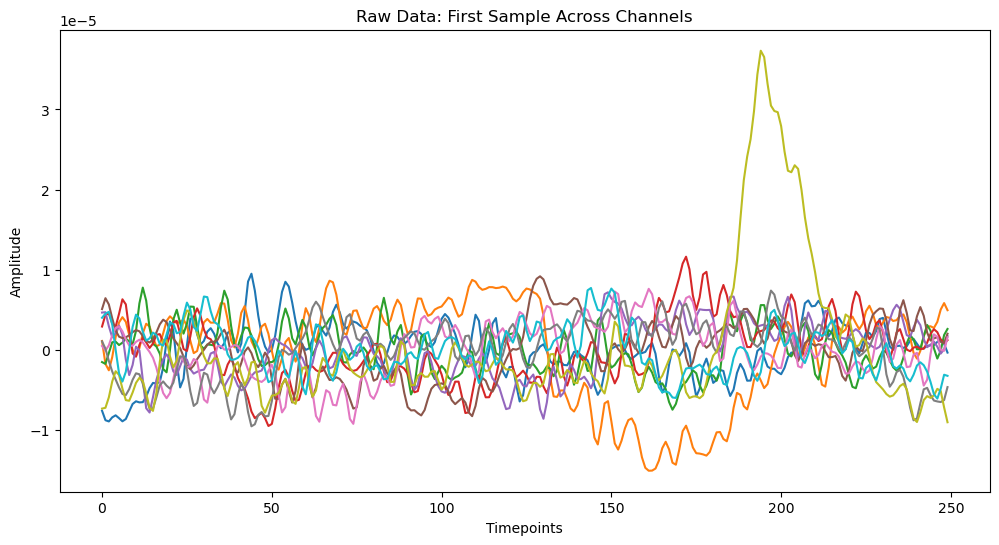

In [9]:
# Plotting before ICA
plt.figure(figsize=(12, 6))
plt.plot(X[0, :, :10])  # Plotting the first 10 timepoints of the first sample across all channels
plt.title('Raw Data: First Sample Across Channels')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.show()

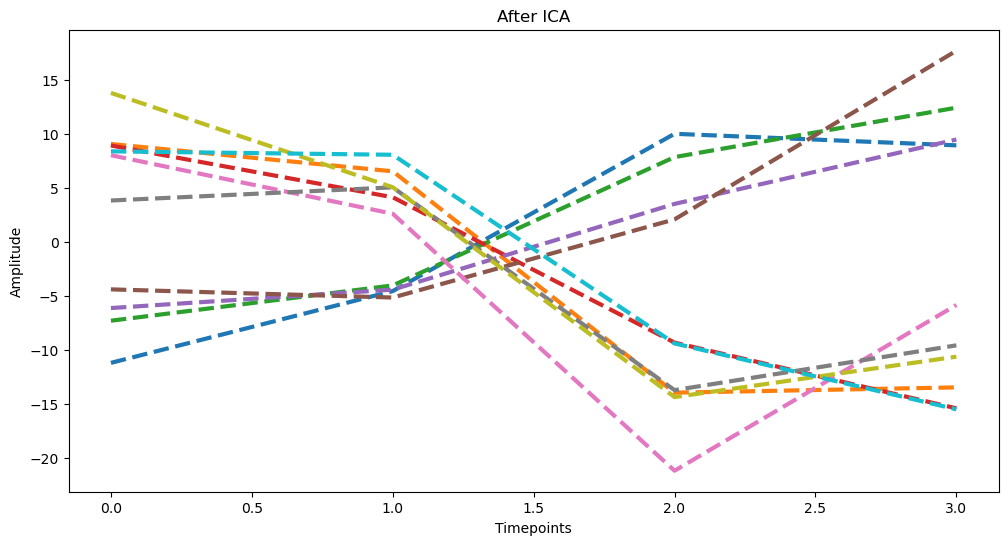

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[12, 6])
ax.plot(unMixed[0, :, :10], '--', lw=3)
plt.title('After ICA')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
# ax.set_xlim(0, 100)

plt.show();

In [13]:
def kurt(x):
    n = np.shape(x)[0]
    mean = np.sum((x**1)/n) # Calculate the mean
    var = np.sum((x-mean)**2)/n # Calculate the variance
    skew = np.sum((x-mean)**3)/n # Calculate the skewness
    kurt = np.sum((x-mean)**4)/n # Calculate the kurtosis
    kurt = kurt/(var**2)-3

    return kurt, skew, var, mean

In [18]:
X.shape, unMixed.shape

((4, 250, 360), (360, 4, 250))

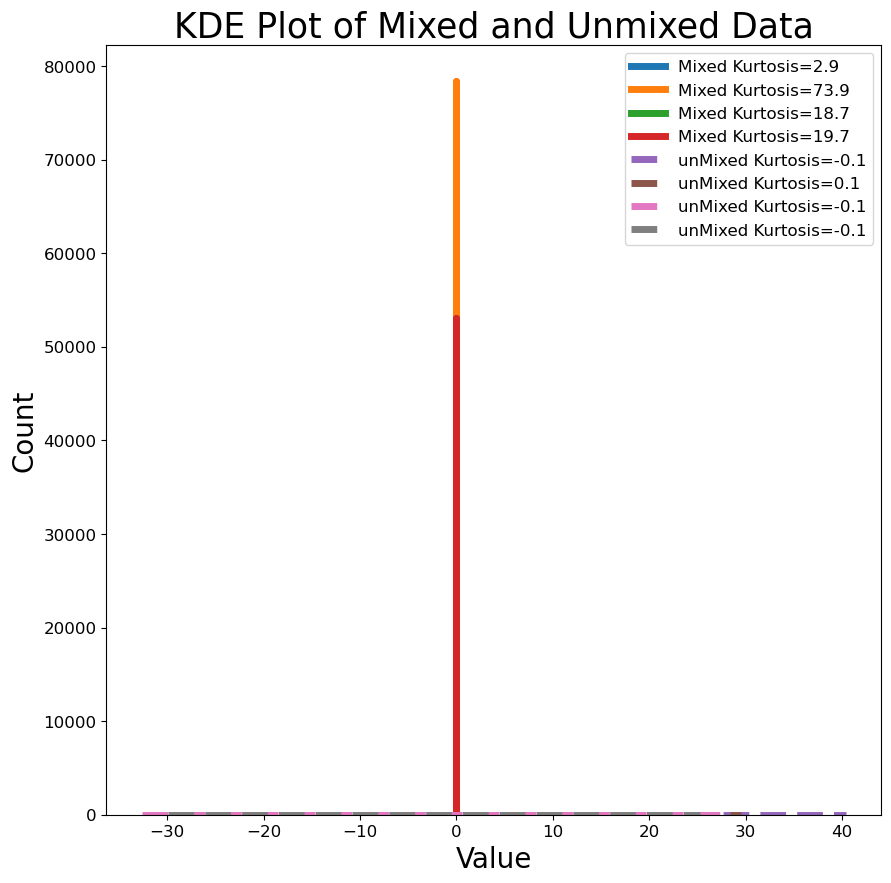

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(X.shape[0]):
    # Plot KDE for mixed data
    sns.kdeplot(X[i, :, :].flatten(), lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :, :].flatten())[0], decimals=1)))

for i in range(X.shape[0]):
    sns.kdeplot(unMixed[i, :, :].flatten(), lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :, :].flatten())[0], decimals=1)))

# Customize plot
ax.tick_params(labelsize=12)
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('KDE Plot of Mixed and Unmixed Data', fontsize=25)
plt.legend(fontsize=12)  # Add legend
plt.show()

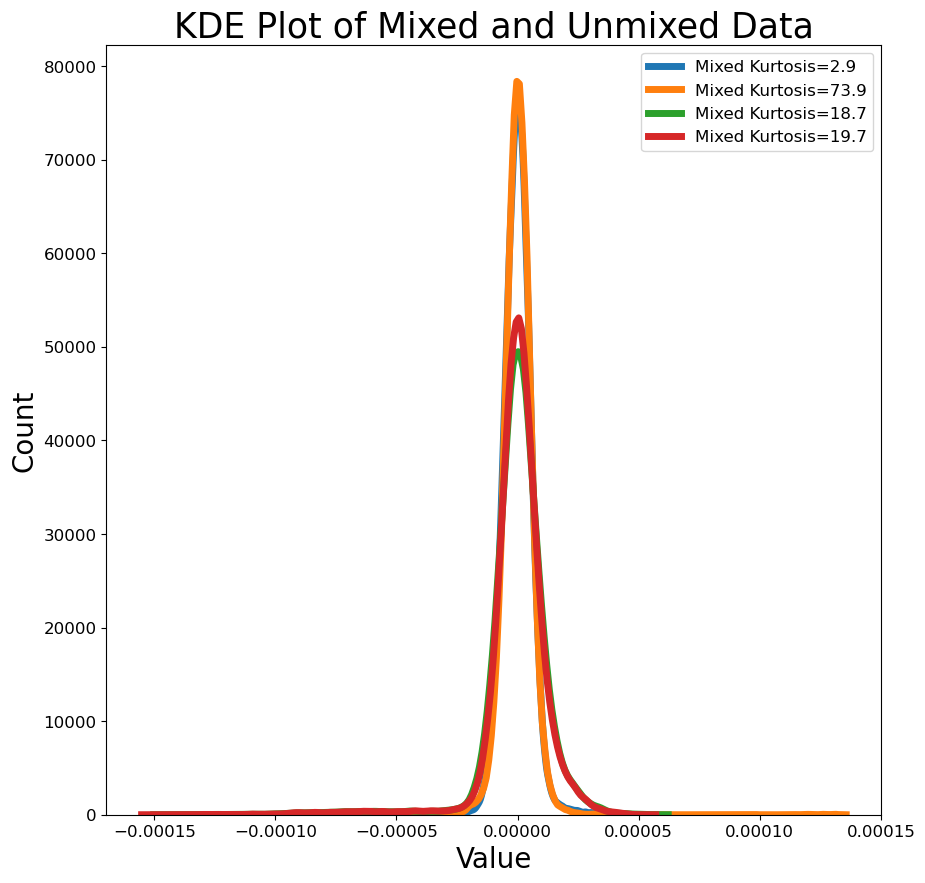

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(X.shape[0]):
    # Plot KDE for mixed data
    sns.kdeplot(X[i, :, :].flatten(), lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :, :].flatten())[0], decimals=1)))

# Customize plot
ax.tick_params(labelsize=12)
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('KDE Plot of Mixed and Unmixed Data', fontsize=25)
plt.legend(fontsize=12)  # Add legend
plt.show()

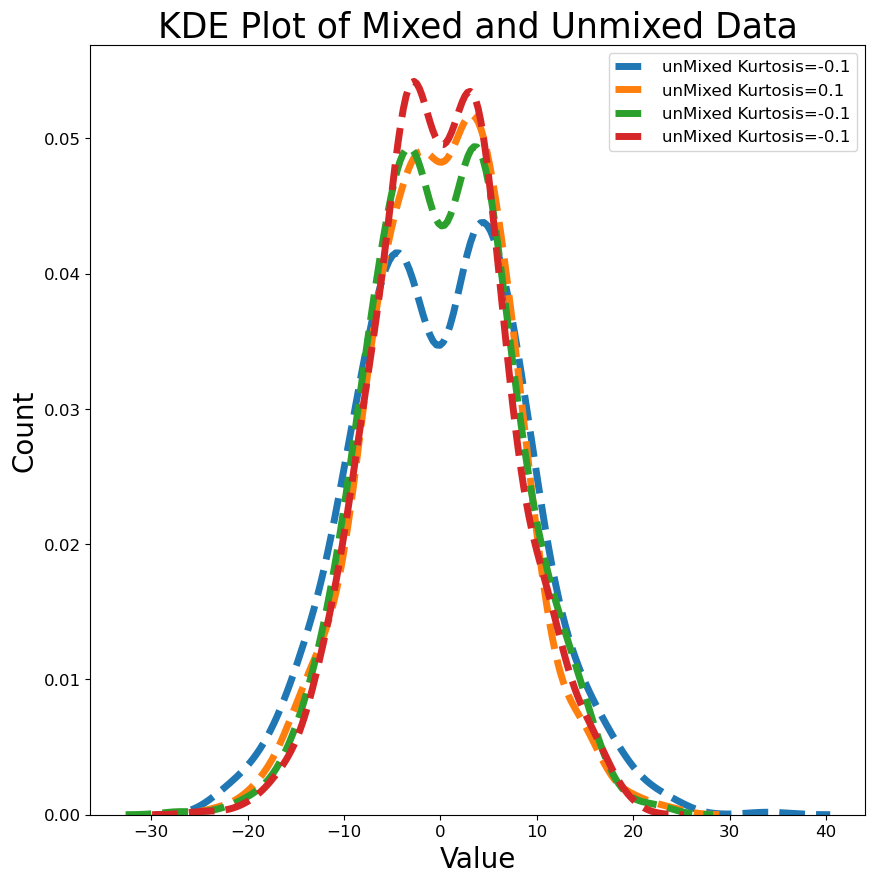

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(X.shape[0]):
    sns.kdeplot(unMixed[i, :, :].flatten(), lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :, :].flatten())[0], decimals=1)))

# Customize plot
ax.tick_params(labelsize=12)
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('KDE Plot of Mixed and Unmixed Data', fontsize=25)
plt.legend(fontsize=12)  # Add legend
plt.show()